# ETA Prediction

- Script Name : Speed Analysis
- Input : SQlite datafiles, with table vehicle_feed.
- Output : 
    - plot between estimated speed from lat-long, and the speed recorded by the sensors.
    - map.html, which displays the speed error across different lat-longs in geoplot.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from tqdm.notebook import tqdm
from datetime import datetime
from random import choice
from glob import glob
## gmplot - dependency to create geoplot
import gmplot

## Data Import
- It takes multiple files as argument using glob, 
- and loads the sqlite data in a matrix

In [9]:
files = glob("/Users/karan/Downloads/feb_20_corrected/*")
db = sqlite3.connect(files[0])
speed_data = db.execute("Select speed, timestamp, route_id, trip_id, lat, lng from vehicle_feed;")

## Functions
- to_radian : Lambda function to convert degree to to_radian
- haversine_dist : function to calculate distance between lat-longs (represented in radians)

In [18]:
to_radian = lambda x : x/57.29577951

def haversine_dist(lat1, lon1, lat2, lon2):
    lat1 = to_radian(lat1)
    lon = to_radian(lon1) - to_radian(lon2)
    lat2 = to_radian(lat2)
    a = np.sin((lat1-lat2) / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon / 2)**2
    c = 2*np.arcsin(np.sqrt(a))

    return 6373.0 * c * 1000

## Re-structuring

- In Sql, each event is represented in the row format, 
- but to analyse the trip wise data over same route.
- We need to restructure the data in tree format, where
    - top level represent city
    - 1st level represents routes
    - 2nd level has arrays indexed with trip id

In [10]:
tree = {}
for e in tqdm(speed_data):
    if int(e[2]) not in tree:
        tree[int(e[2])]  = {}
    if e[3] not in tree[int(e[2])]:
        tree[int(e[2])][e[3]]  = []
        
    tree[int(e[2])][e[3]].append({
        "time" : int(e[1]),
        "speed" : float(e[0]),
        "lat" :  float(e[-2]),
        "long" : float(e[-1])
    })

## Estimating Lat Long Speed of a random trip
- route_choice : randomly select a route.
- trip_choice : randomly selects a trip on that current route.

In [11]:
# Used to store route_choice and trip_choice, in order to backtrack.
history = []

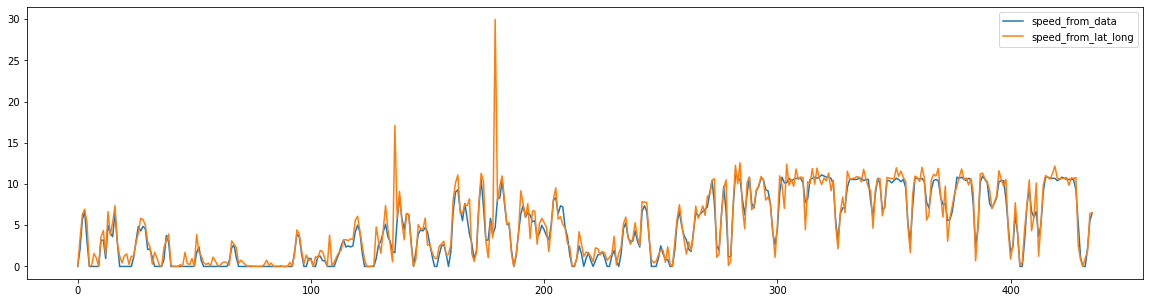

In [32]:
route_choice = choice(list(tree.keys()))
trip_choice = choice(list(tree[route_choice].keys()))
history.append({
    "route_id" : route_choice,
    "trip_id" : trip_choice
})
previous_ts = tree[route_choice][trip_choice][0]
lat_long_speed = [0]
data_speed = [0]
latitude_list = []
longitude_list = []

for current_ts in tree[route_choice][trip_choice][1:]:
    time_taken = (current_ts['time']-previous_ts['time'])
    if time_taken != 0:
        distance_travelled = haversine_dist(previous_ts['lat'], previous_ts['long'], current_ts['lat'], current_ts['long'])
        lat_long_speed.append((distance_travelled/time_taken))
        data_speed.append((current_ts['speed'] + previous_ts['speed'])/2)
        latitude_list.append(current_ts['lat'])
        longitude_list.append(current_ts['long'])
    
    previous_ts = current_ts
data_speed = np.array(data_speed)
lat_long_speed = np.array(lat_long_speed)

gmap3 = gmplot.GoogleMapPlotter(lat = latitude_list[0], lng = longitude_list[0], zoom=15)
for e in range(len(latitude_list)):
    gmap3.marker(latitude_list[e], longitude_list[e], title="{}".format(data_speed[e]*3.6 - lat_long_speed[e]))
gmap3.plot(latitude_list, longitude_list,  
           'cornflowerblue', edge_width = 2.5) 
gmap3.draw( "output/map.html" )


plt.figure(figsize=(20, 5))
plt.plot(data_speed*3.6, label="speed_from_data")
plt.plot(lat_long_speed, label="speed_from_lat_long")
plt.legend()



In [31]:
%%html
<iframe src="./map.html" width="1200" height="1000"></iframe>